In [1]:
# Author: University of Washington Center for Human Rights
# Date: 2019-04-29
# License: GPL 3.0 or greater
# Path: ice-air/analyze/note/nationality.ipynb

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

This notebook and its outputs are of an exploratory nature only and do not necessarily reflect the final findings of UWCHR as published in the report ["Hidden in Plain Sight: ICE Air and the Machinery of Mass Deportation"](https://jsis.washington.edu/humanrights/2019/04/23/ice-air/).

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/passenger-dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air-passengers.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826402 entries, 0 to 1826401
Data columns (total 52 columns):
ANumber                         category
LastName                        category
FirstName                       category
DOB                             category
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  

# By country of citizenship

Define target nationality, check if represented in dataset.

In [3]:
nationality = 'EL SALVADOR'

In [4]:
errormsg = f'{nationality} not represented in dataset'
assert nationality.upper() in df['CountryOfCitizenship'].str.upper().unique(), errormsg

Create DataFrames for removals and transfers, removing duplicate `AlienMasterID` values.

In [5]:
removal_df = df[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')
transfer_df = df[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')

Ranking total removals by `CountryOfCitizenship`. Should implement other comparative statistics.

In [6]:
all_nationalities = removal_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique()
all_nationalities = all_nationalities.sort_values(ascending=False)
all_nationalities = all_nationalities.reset_index().reset_index()
all_nationalities['Rank'] = all_nationalities['index'] + 1
all_nationalities.drop('index', axis=1, inplace=True)
target = all_nationalities.loc[all_nationalities['CountryOfCitizenship'] == nationality].reset_index()
print(f"{nationality}: ranked {target.loc[0, 'Rank']} of {len(all_nationalities)} countries, with {target.loc[0, 'AlienMasterID']} total removals.")
# Probably a better way to do this than with index

EL SALVADOR: ranked 4 of 206 countries, with 164428 total removals.


Create a DataFrame filtered for target nationality only.

In [8]:
nationality_df = df[df['CountryOfCitizenship'] == nationality.upper()]

In [13]:
# Top pickup airports (removals and transfers)
nationality_df['air_AirportName'].value_counts().head(10)

Laredo International Airport                            42755
Alexandria International Airport                        39232
Phoenix-Mesa-Gateway Airport                            30152
San Antonio International Airport                       24788
George Bush Intercontinental Houston Airport            20273
Brownsville South Padre Island International Airport    19837
Valley International Airport                            13233
Harrisburg International Airport                        12585
El Paso International Airport                           12056
Columbus Metropolitan Airport                            8111
Name: air_AirportName, dtype: int64

In [14]:
# Top dropoff airports (removals and transfers)
nationality_df['air2_AirportName'].value_counts().head(10)

El Salvador International Airport                 164299
Alexandria International Airport                   34420
Phoenix-Mesa-Gateway Airport                       21556
El Paso International Airport                       6913
Miami International Airport                         5811
Newark Liberty International Airport                4111
Harrisburg International Airport                    4029
Boeing Field King County International Airport      3527
Columbus Metropolitan Airport                       2889
Gary Chicago International Airport                  2408
Name: air2_AirportName, dtype: int64

In [15]:
nationality_df.set_index('MissionDate', inplace=True)

In [16]:
(nationality_df[nationality_df['R-T'] == 'R']['air2_Country'].value_counts() / len(nationality_df[nationality_df['R-T'] == 'R'])).head()

El Salvador    0.999215
USA            0.000772
Honduras       0.000012
Benin          0.000000
Hungary        0.000000
Name: air2_Country, dtype: float64

In [121]:
nat_removals = nationality_df[nationality_df['R-T'] == 'R']

In [127]:
len(nat_removals['2018'])

15229

In [130]:
nat_removals['2018']['MissionID'].nunique()

153

In [129]:
nat_removals['2018']['air_AirportName'].value_counts().head(5)

Alexandria International Airport                4861
Laredo International Airport                    4706
Phoenix-Mesa-Gateway Airport                    2990
George Bush Intercontinental Houston Airport    1516
San Antonio International Airport                815
Name: air_AirportName, dtype: int64

In [17]:
g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])
# g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'Juvenile', 'NonCriminal'])

In [18]:
# We can improve construction of this table, look at other notebooks
table = g['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = g['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']
table['JuvenileCount'] = g['Juvenile'].sum().reset_index(name='JuvenileCount')['JuvenileCount']
table['JuvPercent'] = table['JuvenileCount'] / table['AlienMasterIDCount']
table['NCCount'] = g['NonCriminal'].sum().reset_index(name='NCCount')['NCCount']
table['NCPercent'] = table['NCCount'] / table['AlienMasterIDCount'] * 100

In [19]:
removals = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [20]:
removals.set_index('MissionDate', inplace=True)
transfers.set_index('MissionDate', inplace=True)

In [30]:
removals.head()

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2010-10-01,EL SALVADOR,R,KCSG,MSLP,33,1,0.0,0.0,0.0,0.0
2010-10-01,EL SALVADOR,R,KIAH,MSLP,86,1,0.0,0.0,0.0,0.0
2010-10-04,EL SALVADOR,R,KELP,MSLP,29,1,0.0,0.0,0.0,0.0
2010-10-04,EL SALVADOR,R,KIWA,MSLP,64,1,0.0,0.0,0.0,0.0
2010-10-06,EL SALVADOR,R,KIWA,MSLP,102,1,0.0,0.0,0.0,0.0


In [27]:
# Total removals
removals['AlienMasterIDCount'].sum()

164428

In [22]:
# Total removal missions
removals['MissionIDCount'].sum()

2643

In [23]:
# Total transfers
transfers['AlienMasterIDCount'].sum()

103385

In [142]:
weekly_removals = removals['AlienMasterIDCount'].resample('W').sum()
weekly_transfers = transfers['AlienMasterIDCount'].resample('W').sum()
weekly_removal_flights = removals['MissionIDCount'].resample('W').sum()
monthly_removals = removals['AlienMasterIDCount'].resample('M').sum()
monthly_transfers = transfers['AlienMasterIDCount'].resample('M').sum()
monthly_removal_flights = removals['MissionIDCount'].resample('M').sum()
monthly_transfers_flights = transfers['MissionIDCount'].resample('M').sum()
annual_removals = removals['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_transfers = transfers['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_removal_flights = removals['MissionIDCount'].resample('AS-OCT').sum()
annual_transfer_flights = transfers['MissionIDCount'].resample('AS-OCT').sum()
annual_juvenile_removals = removals['JuvenileCount'].resample('AS-OCT').sum()

In [143]:
weekly_removal_flights.resample('AS-OCT').mean()

MissionDate
2010-10-01    5.096154
2011-10-01    5.792453
2012-10-01    5.903846
2013-10-01    7.384615
2014-10-01    6.288462
2015-10-01    6.115385
2016-10-01    5.538462
2017-10-01    5.188679
2018-10-01    5.548387
Freq: AS-OCT, Name: MissionIDCount, dtype: float64

In [144]:
weekly_removals.resample('AS-OCT').mean().sort_values()

MissionDate
2017-10-01    279.283019
2010-10-01    296.038462
2018-10-01    318.258065
2016-10-01    348.326923
2011-10-01    349.622642
2015-10-01    381.788462
2012-10-01    385.730769
2014-10-01    414.269231
2013-10-01    505.192308
Name: AlienMasterIDCount, dtype: float64

In [145]:
annual_removals.sum()

164428

In [146]:
annual_removals.index = annual_removals.index.year + 1

In [147]:
annual_removals

MissionDate
2011    15817
2012    18107
2013    20178
2014    26507
2015    21378
2016    20089
2017    17970
2018    14516
2019     9866
Name: AlienMasterIDCount, dtype: int64

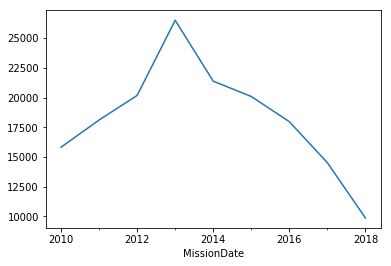

In [47]:
annual_removals.plot()

In [38]:
annual_transfers

MissionDate
2010-10-01     7563
2011-10-01    10023
2012-10-01    16229
2013-10-01    26692
2014-10-01     9938
2015-10-01    11183
2016-10-01     8171
2017-10-01     7566
2018-10-01     6020
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [39]:
annual_juvenile_removals

MissionDate
2010-10-01    44.0
2011-10-01     8.0
2012-10-01     4.0
2013-10-01    41.0
2014-10-01    71.0
2015-10-01    77.0
2016-10-01    89.0
2017-10-01    36.0
2018-10-01    14.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [54]:
removals.reset_index(inplace=True, drop=False)
transfers.reset_index(inplace=True, drop=False)

In [55]:
removals.tail(20)

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
2483,2018-11-09,EL SALVADOR,R,KAEX,MSLP,52,1,0.0,0.000000,30.0,57.692308
2484,2018-11-14,EL SALVADOR,R,KAEX,MSLP,41,1,0.0,0.000000,19.0,46.341463
2485,2018-11-14,EL SALVADOR,R,KIWA,MSLP,71,1,0.0,0.000000,31.0,43.661972
2486,2018-11-15,EL SALVADOR,R,KLRD,MSLP,108,1,0.0,0.000000,71.0,65.740741
2487,2018-11-15,EL SALVADOR,R,KSAT,MSLP,27,1,1.0,0.037037,13.0,48.148148
2488,2018-11-16,EL SALVADOR,R,KAEX,MSLP,37,1,0.0,0.000000,12.0,32.432432
2489,2018-11-16,EL SALVADOR,R,KIAH,MSLP,50,1,0.0,0.000000,21.0,42.000000
2490,2018-11-21,EL SALVADOR,R,KAEX,MSLP,75,1,0.0,0.000000,40.0,53.333333
2491,2018-11-21,EL SALVADOR,R,KIWA,MSLP,34,1,0.0,0.000000,14.0,41.176471
2492,2018-11-21,EL SALVADOR,R,KLRD,MSLP,98,1,0.0,0.000000,81.0,82.653061


In [56]:
removals.to_csv(f'../output/{nationality}_removal_flights.csv')

In [57]:
transfers.head()

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
0,2010-10-01,EL SALVADOR,T,KMCI,KAEX,1,1,0.0,0.0,0.0,0.0
1,2010-10-01,EL SALVADOR,T,KMDT,KAEX,30,1,0.0,0.0,0.0,0.0
2,2010-10-01,EL SALVADOR,T,KOAK,KIWA,2,1,0.0,0.0,0.0,0.0
3,2010-10-02,EL SALVADOR,T,KIWA,KBFI,8,1,0.0,0.0,0.0,0.0
4,2010-10-04,EL SALVADOR,T,KOAK,KIWA,2,1,0.0,0.0,0.0,0.0


In [58]:
# transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
# removals.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [59]:
removals.set_index('MissionDate', inplace=True)

In [60]:
transfers.set_index('MissionDate', inplace=True)

In [61]:
r_cum = removals['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

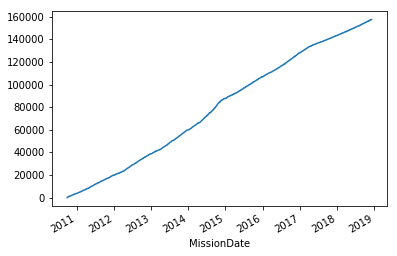

In [62]:
# Cumulative removals
# Based on density of removals, decide whether to use points or line
# r_cum.plot(style='o-')
r_cum.plot(style='-')

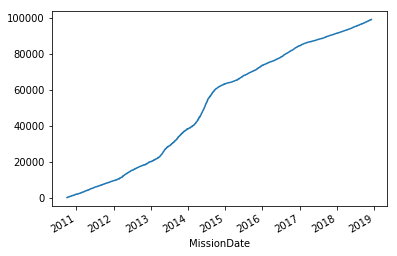

In [63]:
# Cumulative transfers
t_cum.plot()

In [64]:
g = nationality_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'air_AirportName', 'air2_AirportName', 'air2_Country'])[['AlienMasterID', 'MissionID']].nunique()
g.reset_index(inplace=True)
removal_dropoff_airports = g[g['R-T'] == 'R'].copy()
transfer_dropoff_airports = g[g['R-T'] == 'T'].copy()

In [65]:
removal_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)
transfer_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)

In [66]:
removal_dropoff_airports.head()

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
7,2010-10-01,R,Phoenix-Mesa-Gateway Airport,El Salvador International Airport,El Salvador,4074,52
4,2010-10-01,R,George Bush Intercontinental Houston Airport,El Salvador International Airport,El Salvador,3707,58
0,2010-10-01,R,Alexandria International Airport,El Salvador International Airport,El Salvador,2603,41
9,2010-10-01,R,Valley International Airport,El Salvador International Airport,El Salvador,1755,22
8,2010-10-01,R,San Antonio International Airport,El Salvador International Airport,El Salvador,1416,25


In [67]:
transfer_dropoff_airports.head(10)

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
31,2010-10-01,T,Harrisburg International Airport,Alexandria International Airport,USA,1423,59
85,2010-10-01,T,San Diego International Airport,Phoenix-Mesa-Gateway Airport,USA,1268,59
32,2010-10-01,T,Harrisburg International Airport,El Paso International Airport,USA,702,24
45,2010-10-01,T,Meadows Field,Phoenix-Mesa-Gateway Airport,USA,297,88
52,2010-10-01,T,Metropolitan Oakland International Airport,Phoenix-Mesa-Gateway Airport,USA,292,113
26,2010-10-01,T,El Paso International Airport,Phoenix-Mesa-Gateway Airport,USA,234,29
86,2010-10-01,T,Toledo Express Airport,Alexandria International Airport,USA,215,38
62,2010-10-01,T,Ontario International Airport,Phoenix-Mesa-Gateway Airport,USA,213,7
33,2010-10-01,T,Harrisburg International Airport,George Bush Intercontinental Houston Airport,USA,206,6
34,2010-10-01,T,Harrisburg International Airport,Miami International Airport,USA,177,5


In [68]:
# removal_dropoff_airports.to_csv(f'../output/{nationality}_repatriation_dropoff_airports.csv')
# transfer_dropoff_airports.to_csv(f'../output/{nationality}_transfer_dropoff_airports.csv')

In [69]:
removal_dropoff_airports = removal_dropoff_airports.set_index('MissionDate')

In [70]:
removal_sum = removal_dropoff_airports.groupby([pd.Grouper(freq='AS-OCT'), 'air2_AirportName'])[['AlienMasterID']].sum()

In [71]:
removal_sum.reset_index(inplace=True)
removal_sum = removal_sum.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False])

In [72]:
removal_sum.set_index('MissionDate', inplace=True)

In [73]:
removal_sum = removal_sum.dropna()

In [74]:
top_5_df = pd.DataFrame()

for year in removal_sum.index.unique():
    temp = removal_sum.loc[f'{year}'][['air2_AirportName', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['air2_AirportName', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

/Users/philneff/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
/Users/philneff/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [75]:
top_5_df

,0,air2_AirportName,AlienMasterID
air2_AirportName,El Salvador International Airport,NaN,NaN
AlienMasterID,15817,NaN,NaN
2010-10-01 00:00:00,NaN,ALL OTHERS,0.0
2011-10-01 00:00:00,NaN,El Salvador International Airport,18089.0
2011-10-01 00:00:00,NaN,Miami International Airport,8.0
2011-10-01 00:00:00,NaN,Laredo International Airport,6.0
2011-10-01 00:00:00,NaN,Alexandria International Airport,3.0
2011-10-01 00:00:00,NaN,Valley International Airport,1.0
2011-10-01 00:00:00,NaN,ALL OTHERS,0.0
air2_AirportName,El Salvador International Airport,NaN,NaN


In [76]:
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

AttributeError: 'Index' object has no attribute 'year'

In [ ]:
pivot = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='air2_AirportName',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)
cols = list(pivot.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
pivot = pivot[cols]
pivot.columns = pivot.columns.str.title()
pivot.columns.name = 'Drop-off Airport'

In [ ]:
def airport_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.legend(fontsize=12)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_inches='tight')
    return fig, ax

In [ ]:
airport_trend(pivot,
              title=f'{nationality.title()} \n Top Dropoff Airports for Removals',
              filename=f'{nationality}_top_removal_airports',
              ylabel='Total Removals',
              xlabel='Fiscal Year');

## Juveniles only

In [75]:
removals['JuvenileCount'].resample('AS-OCT').sum()

MissionDate
2010-10-01    44.0
2011-10-01     8.0
2012-10-01     4.0
2013-10-01    41.0
2014-10-01    71.0
2015-10-01    77.0
2016-10-01    89.0
2017-10-01    36.0
2018-10-01    14.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [63]:
juv_r_cum = removals['JuvenileCount'].cumsum()

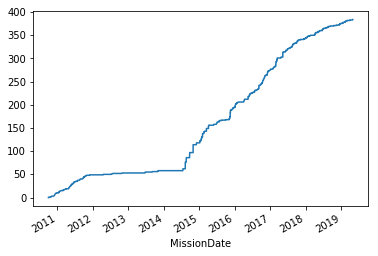

In [64]:
juv_r_cum.plot()

In [65]:
removals.tail(20)

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2019-04-11,EL SALVADOR,R,KAEX,MSLP,103,1,0.0,0.000000,32.0,31.067961
2019-04-11,EL SALVADOR,R,KLRD,MSLP,109,1,0.0,0.000000,89.0,81.651376
2019-04-11,EL SALVADOR,R,KSAT,MSLP,13,1,0.0,0.000000,7.0,53.846154
2019-04-12,EL SALVADOR,R,KAEX,MSLP,19,1,0.0,0.000000,10.0,52.631579
2019-04-12,EL SALVADOR,R,KLRD,MSLP,135,1,0.0,0.000000,63.0,46.666667
2019-04-24,EL SALVADOR,R,KELP,MSLP,39,1,0.0,0.000000,15.0,38.461538
2019-04-24,EL SALVADOR,R,KIWA,MSLP,69,1,0.0,0.000000,35.0,50.724638
2019-04-24,EL SALVADOR,R,KLRD,MSLP,111,1,0.0,0.000000,28.0,25.225225
2019-04-24,EL SALVADOR,R,KSAT,MSLP,11,1,0.0,0.000000,8.0,72.727273


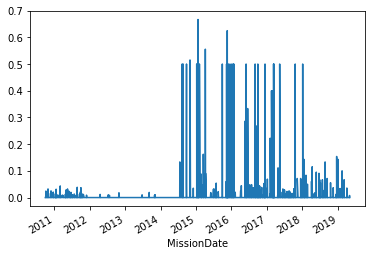

In [66]:
removals['JuvPercent'].plot();

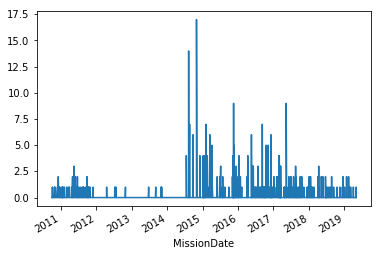

In [67]:
removals['JuvenileCount'].plot();

In [68]:
removals[removals['JuvPercent'] > .5]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2014-10-31,EL SALVADOR,R,KSAT,MSLP,33,1,17.0,0.515152,33.0,100.0
2015-01-22,EL SALVADOR,R,KSAT,MSLP,6,1,4.0,0.666667,6.0,100.0
2015-04-07,EL SALVADOR,R,KSAT,MSLP,9,1,5.0,0.555556,9.0,100.0
2015-11-19,EL SALVADOR,R,KSAT,MSLP,8,1,5.0,0.625000,4.0,50.0


In [69]:
transfers['JuvenileCount'].value_counts()

0.0     8824
1.0       68
4.0       59
3.0       49
5.0       48
2.0       45
6.0       45
7.0       44
8.0       39
10.0      37
11.0      28
9.0       27
13.0      26
12.0      24
14.0      21
16.0      20
20.0      14
17.0      12
18.0      11
15.0      11
19.0       7
21.0       6
24.0       6
23.0       5
39.0       5
27.0       5
22.0       5
28.0       4
30.0       4
35.0       4
36.0       3
26.0       3
33.0       3
44.0       2
32.0       2
49.0       2
34.0       2
25.0       2
42.0       2
51.0       1
45.0       1
54.0       1
65.0       1
46.0       1
38.0       1
40.0       1
43.0       1
50.0       1
37.0       1
29.0       1
Name: JuvenileCount, dtype: int64

In [70]:
removals[removals['JuvenileCount'] > 20]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,


# KBFI only

In [130]:
airport = 'KBFI'

In [131]:
airport_removals = pd.concat([removals[removals['PULOC'] == airport], removals[removals['DropLoc'] == airport]])

In [132]:
airport_removals

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2010-10-02,MEXICO,R,KBFI,KSAN,53,1,0.0,0.000000,0.0,0.000000
2010-10-06,MEXICO,R,KBFI,KHRL,18,1,0.0,0.000000,0.0,0.000000
2010-10-09,MEXICO,R,KBFI,KSAN,63,1,0.0,0.000000,0.0,0.000000
2010-10-13,MEXICO,R,KBFI,KHRL,27,1,0.0,0.000000,0.0,0.000000
2010-10-16,MEXICO,R,KBFI,KSAN,47,1,1.0,0.021277,0.0,0.000000
2010-10-23,MEXICO,R,KBFI,KSAN,99,1,0.0,0.000000,0.0,0.000000
2010-10-27,MEXICO,R,KBFI,KHRL,20,1,0.0,0.000000,0.0,0.000000
2010-10-30,MEXICO,R,KBFI,KSAN,92,1,0.0,0.000000,0.0,0.000000
2010-11-03,MEXICO,R,KBFI,KHRL,47,1,0.0,0.000000,0.0,0.000000


In [133]:
airport_transfers = pd.concat([transfers[transfers['PULOC'] == airport], transfers[transfers['DropLoc'] == airport]])

In [134]:
airport_transfers.to_csv(f'../output/{nationality}_transfers_tofrom_{airport}.csv')

In [135]:
airport_weekly_removals = airport_removals['AlienMasterIDCount'].resample('W').nunique()
airport_weekly_transfers = airport_transfers['AlienMasterIDCount'].resample('W').nunique()
airport_monthly_removals = airport_removals['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_transfers = airport_transfers['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_removal_flights = airport_removals['MissionIDCount'].resample('M').nunique()
airport_monthly_transfers_flights = airport_transfers['MissionIDCount'].resample('M').nunique()
airport_annual_removals = airport_removals['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_transfers = airport_transfers['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_removal_flights = airport_removals['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_transfer_flights = airport_transfers['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_juvenile_removals = airport_removals['JuvenileCount'].resample('AS-OCT').sum()
airport_annual_juvenile_transfers = airport_transfers['JuvenileCount'].resample('AS-OCT').sum()

In [136]:
airport_annual_removals

MissionDate
2010-10-01    62
2011-10-01    56
2012-10-01    40
2013-10-01    20
2014-10-01    15
2015-10-01    12
2016-10-01    14
2017-10-01    25
2018-10-01     8
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [137]:
airport_annual_removal_flights

MissionDate
2010-10-01    1
2011-10-01    1
2012-10-01    1
2013-10-01    1
2014-10-01    1
2015-10-01    1
2016-10-01    1
2017-10-01    1
2018-10-01    1
Freq: AS-OCT, Name: MissionIDCount, dtype: int64

In [138]:
airport_annual_juvenile_removals

MissionDate
2010-10-01    13.0
2011-10-01     8.0
2012-10-01     2.0
2013-10-01     0.0
2014-10-01     0.0
2015-10-01     0.0
2016-10-01     0.0
2017-10-01     4.0
2018-10-01     0.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [139]:
airport_annual_transfers

MissionDate
2010-10-01    14
2011-10-01    13
2012-10-01    32
2013-10-01    46
2014-10-01    34
2015-10-01    40
2016-10-01    40
2017-10-01    43
2018-10-01     7
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [140]:
airport_annual_transfer_flights

MissionDate
2010-10-01    1
2011-10-01    1
2012-10-01    1
2013-10-01    1
2014-10-01    1
2015-10-01    1
2016-10-01    1
2017-10-01    1
2018-10-01    1
Freq: AS-OCT, Name: MissionIDCount, dtype: int64

In [141]:
airport_annual_juvenile_transfers

MissionDate
2010-10-01    0.0
2011-10-01    0.0
2012-10-01    0.0
2013-10-01    4.0
2014-10-01    0.0
2015-10-01    0.0
2016-10-01    0.0
2017-10-01    0.0
2018-10-01    0.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64